# Regression Analysis Cultura Data

This notebook provides an overview of the statistical analysis that complements the main results in our paper. We primarily aim to test the hypothesis that the cultural production score can serve as a proxy for GDP. To evaluate this proposition, we use regression models where GDP is the dependent variable, and cultural production is one of the independent variables. We employ Bayesian Regression Modeling with Bambi—built upon PyMC—for a robust assessment of the correlation between these two variables. But before we delve into the models, we will first load and normalize the data to streamline the processing.

## Data Preparation

In [2]:
import numpy as np
import bambi as bmb
import pandas as pd
import arviz as az

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### For up  to 1850

In [3]:
df_gdp = pd.read_csv("data/gdp_weighted_pop_decade.csv")
df_gdp = df_gdp.rename(columns={"region": "region_name"})

#df_cultura = pd.read_csv("../unseen_species_model/results/occupation/raw_results.csv", index_col = [0])
df_cultura = pd.read_csv("../3-unseen_species_index/unseen_species_model/unseen_species_model_bayesian.csv", index_col = [0])

df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura['survival_ratio'] = df_cultura['score']/df_cultura['N_est']

# Add indiviudals not taken into account into the unseen-species model
df_works = pd.read_csv('../2-cultura_database_extract/db_extract/df_indi__work>2.csv', index_col=[0])
df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
df_cultura = df_cultura.fillna(0)
df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']

df = pd.merge(df_gdp, df_cultura, on = ['region_name', 'decade'])
df = df.rename(columns = {'decade': 'year', 'gdp_pc_weighted':'gdp_per_capita'})
df['score_cap'] = df['score']/df['pop']
df['N_est_cap'] = df['N_est']/df['pop']


In [4]:



list(set(df.region_name))
df.region_name.value_counts()

keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])

df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()

df["N_est_std"] = df["N_est"] / df["N_est"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()

df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()

df["log_gdp"] = np.log(df["gdp_per_capita"])
df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df["gdp_std"] = df["gdp_per_capita"] / df["gdp_per_capita"].mean()

df["survival_ratio_std"] = df["survival_ratio"] / df["survival_ratio"].mean()

df.sample(5)

,region_name,year,gdp_per_capita,pop,N_est,score,survival_ratio,f>3,score_cap,N_est_cap,...,N_est_cap_log,score_log_std,score_cap_log_std,N_est_std,N_est_log_std,N_est_cap_log_std,log_gdp,log_gdp_std,gdp_std,survival_ratio_std
464,United Kingdom,1380,1496.454545,3475.920000,102.230509,10,0.098784,1.0,0.002877,0.029411,...,-3.526384,0.667956,1.036341,0.026113,0.742583,1.232228,7.310854,0.986663,0.841565,1.356114
508,United Kingdom,1830,3515.333333,24118.333333,7654.355052,594,0.079228,157.0,0.024629,0.317367,...,-1.147697,1.852768,0.656030,1.955176,1.435187,0.401041,8.164890,1.101922,1.976926,1.087642
91,France,1640,1490.506966,19688.400000,4559.312818,230,0.050825,34.0,0.011682,0.231574,...,-1.462858,1.577531,0.788137,1.164600,1.352041,0.511168,7.306872,0.986125,0.838220,0.697729
371,Portugal,1700,1632.344333,2002.465909,187.856584,11,0.058555,0.0,0.005493,0.093813,...,-2.366456,0.695605,0.921781,0.047985,0.840227,0.826913,7.397773,0.998393,0.917985,0.803848
301,Low countries,1840,3543.181818,2887.272727,6739.374353,524,0.078971,104.0,0.181486,2.334166,...,0.847655,1.816394,0.302271,1.721460,1.414757,-0.296197,8.172780,1.102987,1.992588,1.084110


We apply a logarithmic transformation to the GDP to account for its exponential growth, as our interest lies in variables that maintain a linear correlation with GDP. We also center this at 1, which aids in straightforward interpretation. We employ the same strategy to both the production score (`score`) and the bias-corrected production score (`N_est`):

Explanation of columns:

- score: Immaterial Index (number of CPs per decade per region)
- N_est: Corrected Immaterial Index with the Unseen Species Model
- score_cap: Immaterial Index per capita (Immaterial Index/Population)
- N_est_cap: Corrected Immaterial Index per capita
- score_log: Natural Log of Immaterial Index
- score_log_std: Standardized Natural Log of Immaterial Index
- score_cap_log: Natural Log of Immaterial Index per capita
- N_est_cap_log: Natural Log of Corrected Immaterial Index per capita
- N_est_cap_log_std: Standardized Natural Log of Corrected Immaterial Index per capita
- gdp: GPD per capita
- log_gdp: Natural Log of GDP per capita
- log_gdp_std: Standardized Natural Log of GDP per capita

The distribution of the logged GDP values is clearly trimodal:

## Visualy plot the relationships

In [5]:
# df_cultura = pd.read_csv("../unseen_species_model/results_50/raw_results.csv", index_col = [0])
# df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
# df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
# df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
# df_cultura['survival_ratio'] = df_cultura['score']/df_cultura['N_est']
# df_cultura['score_log'] = np.log(df_cultura['score'])
# df_cultura['N_est_log'] = np.log(df_cultura['N_est'])
# df_cultura['log_diff_scores'] = df_cultura['N_est_log']-df_cultura['score_log']
# df_cultura = df_cultura.rename(columns = {'decade': 'year'})

#### OLS Model

In [6]:
df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std']].copy()
df_ols

,region_name,year,log_gdp_std,N_est_log_std
0,Arabic world,730,0.961642,0.543561
1,Arabic world,1000,0.939651,0.464254
2,Arabic world,1120,0.940206,0.565556
3,Arabic world,1280,0.941140,0.704602
4,Arabic world,1300,0.928428,0.627832
...,...,...,...,...
509,United Kingdom,1840,1.118742,1.514581
510,United Kingdom,1850,1.135013,1.514499
511,United Kingdom,1860,1.150244,1.550608
512,United Kingdom,1870,1.167039,1.506495


In [7]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()


# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 514     Method:             REML       
No. Groups:       16      Scale:              0.0006     
Min. group size:  1       Log-Likelihood:     1128.3399  
Max. group size:  64      Converged:          Yes        
Mean group size:  32.1                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.923    0.010 90.770 0.000  0.903  0.943
N_est_log_std   0.065    0.004 15.880 0.000  0.057  0.073
Group Var       0.001    0.021                           



/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


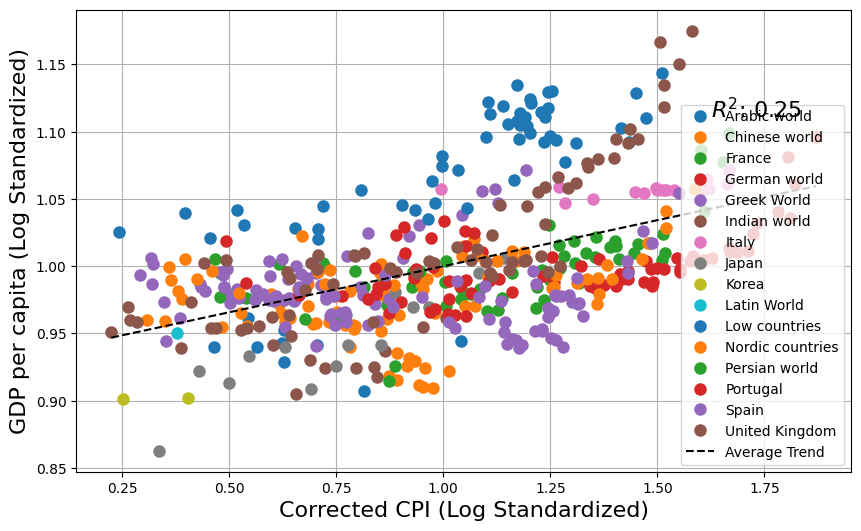

In [8]:
# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['N_est_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Corrected CPI (Log Standardized)', fontsize=16)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=16)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.2f}', ha='right', fontsize=16)

plt.show()

### GDP per capita vs Corrected Index

In [9]:
models = {}

priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

corrected_index_fifty = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

corrected_index_fifty_fit = corrected_index_fifty.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)"] = corrected_index_fifty_fit

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyT

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5896 seconds.


In [10]:
summary_table_50 = az.summary(corrected_index_fifty_fit)
summary_table_50 = summary_table_50[['mean', 'sd', 'hdi_3%','hdi_97%']]
summary_table_50.iloc[1]

mean       0.044
sd         0.017
hdi_3%     0.013
hdi_97%    0.075
Name: N_est_log_std, dtype: float64

### Visualization

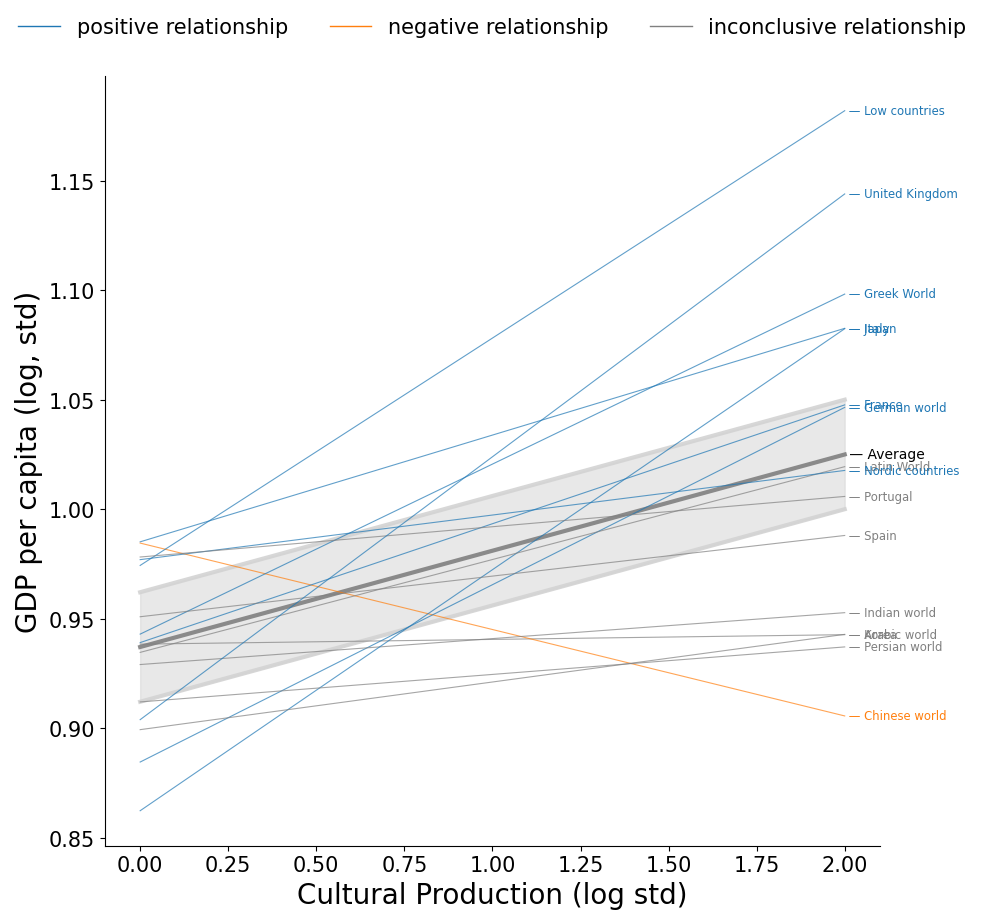

In [11]:
# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

posterior = az.extract(corrected_index_fifty_fit)

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr


intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]


score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots(figsize=(10, 10))

ratio_li = az.summary(corrected_index_fifty_fit).loc['Intercept']['hdi_3%']/az.summary(corrected_index_fifty_fit).loc['Intercept']['mean']
ratio_ui = az.summary(corrected_index_fifty_fit).loc['Intercept']['hdi_97%']/az.summary(corrected_index_fifty_fit).loc['Intercept']['mean']

Y = (intercept_common + slope_common * score_xi)
Y_mean = Y.mean(axis=0)

Y_min = (intercept_common*ratio_li + slope_common * score_xi)
Y_min = Y_min.mean(axis=0)

Y_max = (intercept_common*ratio_ui + slope_common * score_xi)
Y_max = Y_max.mean(axis=0)


color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
        "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
        "grey")

ax.plot(score_xi, Y_mean, color=color, alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_min, color="lightgrey", alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_max, color="lightgrey", alpha=0.9, lw=3, label="Average")

# Plotting the confidence interval in light grey
ax.fill_between(score_xi, Y_min, Y_max, color='lightgrey', alpha=0.5)


ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + "Average",
        size="medium",
        color="black",
        ha="left",
        va="center",
    )

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]


a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific


for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]

# Set the font sizes for ticks, labels, and legend
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel("Cultural Production (log std)", fontsize=20)
ax.set_ylabel("GDP per capita (log, std)", fontsize=20)

custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=15)



#### Only Score

In [12]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

score_index_fifty = bmb.Model(
    "log_gdp_std ~  score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

score_index_fifty_fit = score_index_fifty.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})


az.summary(score_index_fifty_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency


posterior = az.extract(score_index_fifty_fit)

models["log_gdp_std ~  score_log_std + (score_log_std|region_name)"] = score_index_fifty_fit

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyT

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6990 seconds.


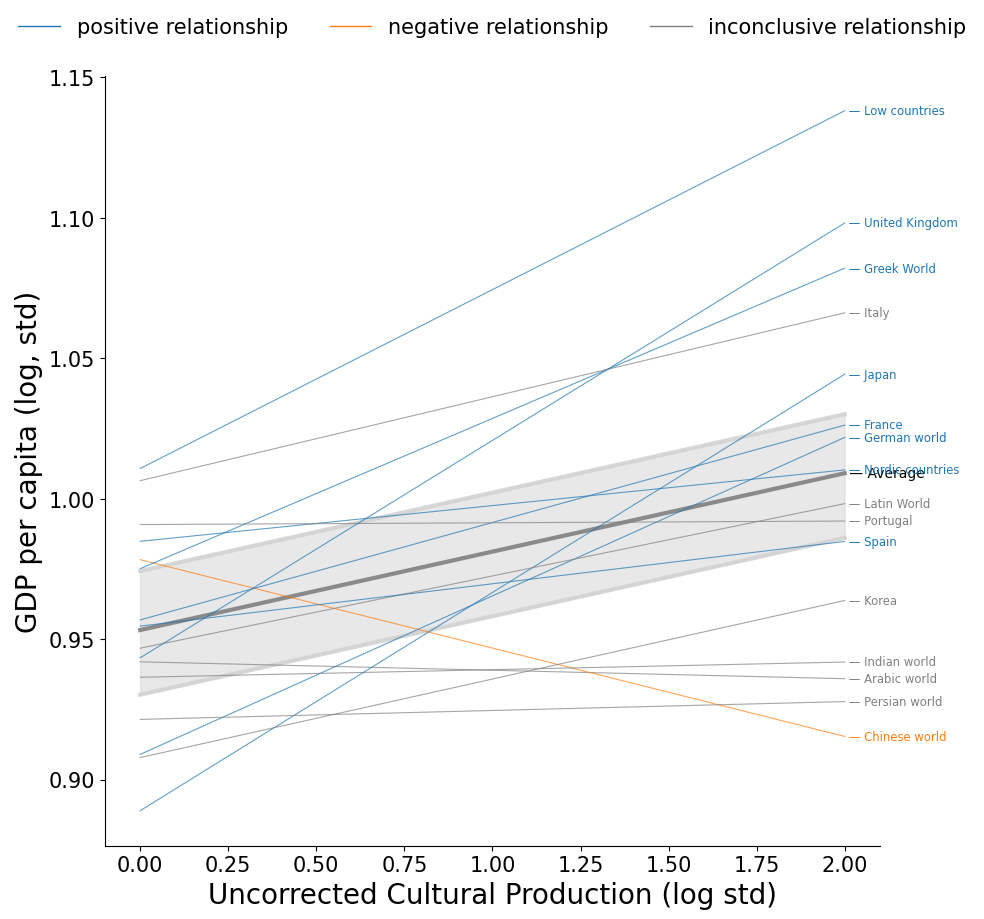

In [13]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots(figsize=(10, 10))


ratio_li = az.summary(score_index_fifty_fit).loc['Intercept']['hdi_3%']/az.summary(score_index_fifty_fit).loc['Intercept']['mean']
ratio_ui = az.summary(score_index_fifty_fit).loc['Intercept']['hdi_97%']/az.summary(score_index_fifty_fit).loc['Intercept']['mean']

Y = (intercept_common + slope_common * score_xi)
Y_mean = Y.mean(axis=0)

Y_min = (intercept_common*ratio_li + slope_common * score_xi)
Y_min = Y_min.mean(axis=0)

Y_max = (intercept_common*ratio_ui + slope_common * score_xi)
Y_max = Y_max.mean(axis=0)

color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
        "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
        "grey")

ax.plot(score_xi, Y_mean, color=color, alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_min, color="lightgrey", alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_max, color="lightgrey", alpha=0.9, lw=3, label="Average")

# Plotting the confidence interval in light grey
ax.fill_between(score_xi, Y_min, Y_max, color='lightgrey', alpha=0.5)
ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + "Average",
        size="medium",
        color="black",
        ha="left",
        va="center",
    )


for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]


# Set the font sizes for ticks, labels, and legend
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel("Uncorrected Cultural Production (log std)", fontsize=20)
ax.set_ylabel("GDP per capita (log, std)", fontsize=20)

custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=15)




/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn

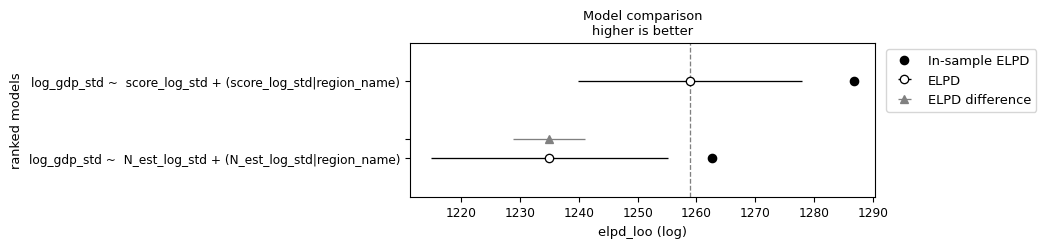

In [14]:
waic_compare = az.compare(models, ic='LOO')
az.plot_compare(waic_compare, insample_dev=True);

In [15]:
# az.summary(score_index_fifty_fit)

## For the modern period (1800-1880)

In [16]:
df_gdp = pd.read_csv("data/gdp_weighted_pop_decade.csv")
df_gdp = df_gdp.rename(columns={"region": "region_name"})

#df_cultura = pd.read_csv("../unseen_species_model/results/occupation/raw_results.csv", index_col = [0])
df_cultura = pd.read_csv("../3-unseen_species_index/unseen_species_model/unseen_species_model_bayesian.csv", index_col = [0])

df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura['survival_ratio'] = df_cultura['score']/df_cultura['N_est']

# Add indiviudals not taken into account into the unseen-species model
df_works = pd.read_csv('../2-cultura_database_extract/db_extract/df_indi__work>2.csv', index_col=[0])
df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
df_cultura = df_cultura.fillna(0)
df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']

df = pd.merge(df_gdp, df_cultura, on = ['region_name', 'decade'])
df = df.rename(columns = {'decade': 'year', 'gdp_pc_weighted':'gdp_per_capita'})
df['score_cap'] = df['score']/df['pop']
df['N_est_cap'] = df['N_est']/df['pop']

df = df[df['year']>=1800]

list(set(df.region_name))
df.region_name.value_counts()

keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])

df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()

df["N_est_std"] = df["N_est"] / df["N_est"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()

df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()
df["log_gdp"] = np.log(df["gdp_per_capita"])

df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df["gdp_std"] = df["gdp_per_capita"] / df["gdp_per_capita"].mean()
df["survival_ratio_std"] = df["survival_ratio"] / df["survival_ratio"].mean()

df.sample(5)

,region_name,year,gdp_per_capita,pop,N_est,score,survival_ratio,f>3,score_cap,N_est_cap,...,N_est_cap_log,score_log_std,score_cap_log_std,N_est_std,N_est_log_std,N_est_cap_log_std,log_gdp,log_gdp_std,gdp_std,survival_ratio_std
115,France,1880,3444.090909,39024.909091,32489.232209,2090,0.065044,357.0,0.053556,0.832526,...,-0.183291,1.515803,0.621232,2.733925,1.307741,0.101201,8.144415,1.079044,1.607772,1.058134
218,Indian world,1860,896.000000,245110.000000,193.052510,23,0.123621,7.0,0.000094,0.000788,...,-7.146500,0.621693,1.968301,0.016245,0.662510,3.945813,6.797940,0.900651,0.418271,2.011071
344,Nordic countries,1810,1338.222222,2463.583333,4742.483785,198,0.042007,29.0,0.080371,1.925035,...,0.654944,1.048536,0.535078,0.399074,1.065501,-0.361616,7.199097,0.953800,0.624710,0.683374
49,Chinese world,1810,901.000000,360750.000000,229.934911,27,0.118455,2.0,0.000075,0.000637,...,-7.358144,0.653485,2.016296,0.019349,0.684518,4.062668,6.803505,0.901388,0.420605,1.927028
299,Low countries,1820,2937.376720,2463.822917,2975.021510,241,0.081861,31.0,0.097815,1.207482,...,0.188537,1.087503,0.493387,0.250344,1.006801,-0.104097,7.985272,1.057959,1.371228,1.331715


### For corrected index

In [17]:
# models = {}

priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

corrected_index_decade = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

corrected_index_decade_fit = corrected_index_decade.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})


models["log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name) (1800-1880)"] = corrected_index_decade_fit

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyT

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2847 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


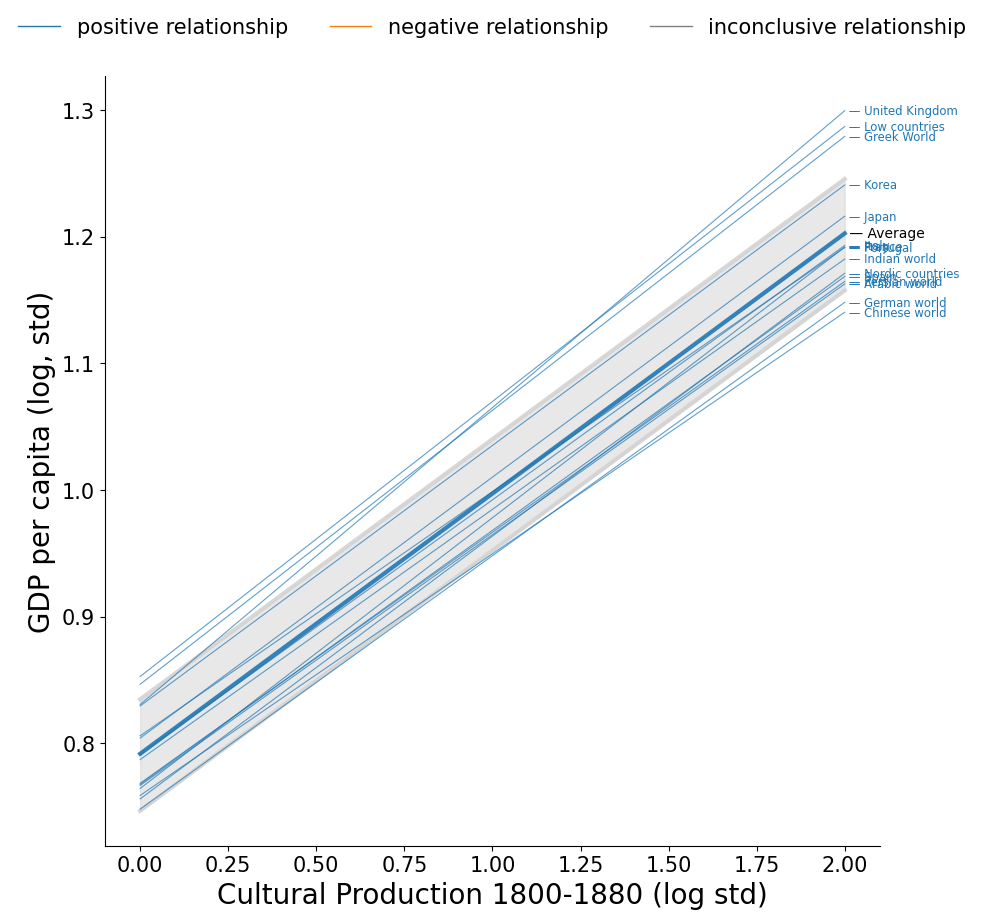

In [18]:

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

posterior = az.extract(corrected_index_decade_fit)

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr


intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]


score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots(figsize=(10, 10))

ratio_li = az.summary(corrected_index_decade_fit).loc['Intercept']['hdi_3%']/az.summary(corrected_index_decade_fit).loc['Intercept']['mean']
ratio_ui = az.summary(corrected_index_decade_fit).loc['Intercept']['hdi_97%']/az.summary(corrected_index_decade_fit).loc['Intercept']['mean']

Y = (intercept_common + slope_common * score_xi)
Y_mean = Y.mean(axis=0)

Y_min = (intercept_common*ratio_li + slope_common * score_xi)
Y_min = Y_min.mean(axis=0)

Y_max = (intercept_common*ratio_ui + slope_common * score_xi)
Y_max = Y_max.mean(axis=0)


color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
        "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
        "grey")

ax.plot(score_xi, Y_mean, color=color, alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_min, color="lightgrey", alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_max, color="lightgrey", alpha=0.9, lw=3, label="Average")

# Plotting the confidence interval in light grey
ax.fill_between(score_xi, Y_min, Y_max, color='lightgrey', alpha=0.5)


ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + "Average",
        size="medium",
        color="black",
        ha="left",
        va="center",
    )

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]


a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific


for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
# Set the font sizes for ticks, labels, and legend
ax.tick_params(axis='both', labelsize=15)

ax.set_xlabel("Cultural Production 1800-1880 (log std)", fontsize=20)
ax.set_ylabel("GDP per capita (log, std)", fontsize=20)

custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=15)


#### Score for modern period

In [19]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

score_index_decade = bmb.Model(
    "log_gdp_std ~  score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

score_index_decade_fit = score_index_decade.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})


models["log_gdp_std ~  score_log_std + (score_log_std|region_name) (1800-1880)"] = score_index_decade_fit

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyT

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5039 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


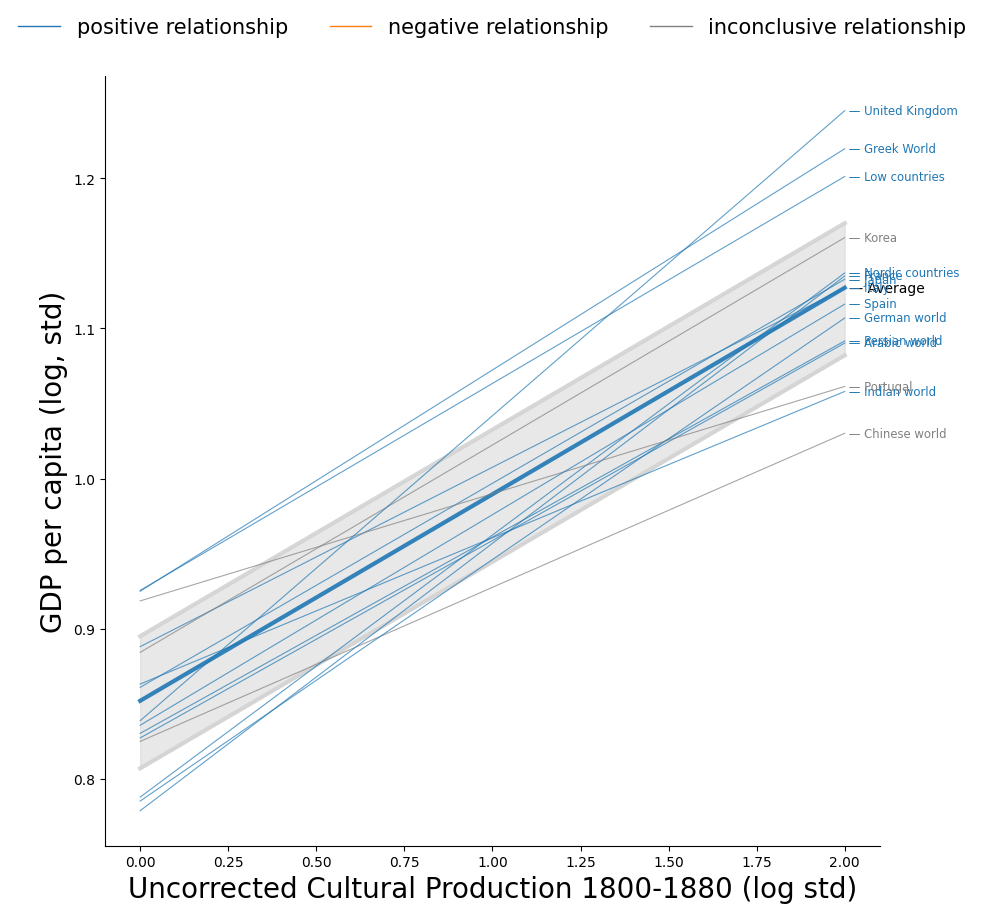

In [20]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr


posterior = az.extract(score_index_decade_fit)

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots(figsize=(10, 10))


ratio_li = az.summary(score_index_decade_fit).loc['Intercept']['hdi_3%']/az.summary(score_index_decade_fit).loc['Intercept']['mean']
ratio_ui = az.summary(score_index_decade_fit).loc['Intercept']['hdi_97%']/az.summary(score_index_decade_fit).loc['Intercept']['mean']

Y = (intercept_common + slope_common * score_xi)
Y_mean = Y.mean(axis=0)

Y_min = (intercept_common*ratio_li + slope_common * score_xi)
Y_min = Y_min.mean(axis=0)

Y_max = (intercept_common*ratio_ui + slope_common * score_xi)
Y_max = Y_max.mean(axis=0)

color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
        "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
        "grey")

ax.plot(score_xi, Y_mean, color=color, alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_min, color="lightgrey", alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_max, color="lightgrey", alpha=0.9, lw=3, label="Average")

# Plotting the confidence interval in light grey
ax.fill_between(score_xi, Y_min, Y_max, color='lightgrey', alpha=0.5)
ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + "Average",
        size="medium",
        color="black",
        ha="left",
        va="center",
    )


for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.set_xlabel("Uncorrected Cultural Production 1800-1880 (log std)", fontsize=20)
ax.set_ylabel("GDP per capita (log, std)", fontsize=20)

custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=15)


#### Model Comparison

In [21]:
models_fifty = {}
models_fifty["log_gdp_std ~  N_log_std + (N_log_std|region_name)"] = corrected_index_fifty_fit
models_fifty["log_gdp_std ~  score_log_std + (score_log_std|region_name)"] = score_index_fifty_fit

models_decade = {}
models_decade["log_gdp_std ~  N_log_std + (N_log_std|region_name) (1800-1880)"] = corrected_index_decade_fit
models_decade["log_gdp_std ~  score_log_std + (score_log_std|region_name) (1800-1880)"] = score_index_decade_fit

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incomp

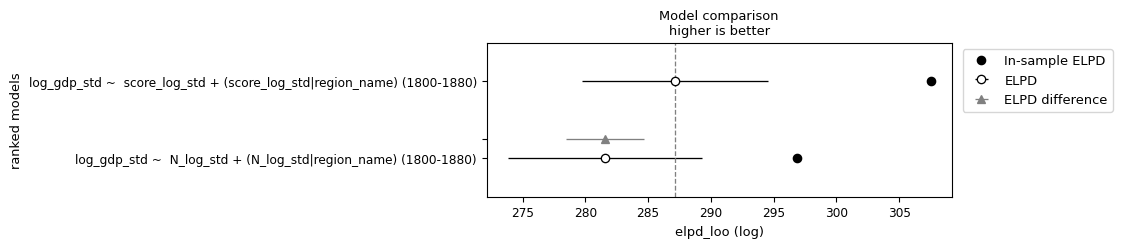

In [22]:
waic_compare = az.compare(models_decade, ic='LOO')
az.plot_compare(waic_compare, insample_dev=True);

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn

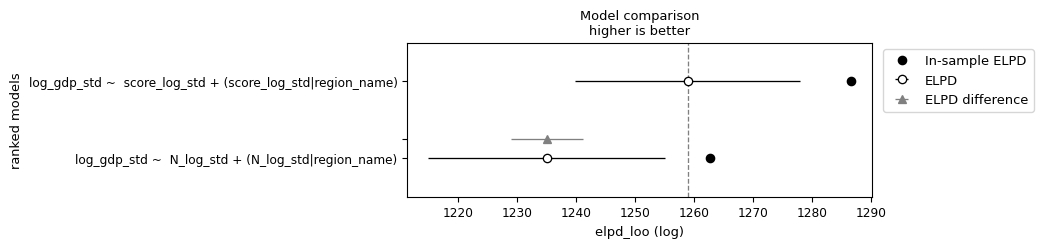

In [23]:
waic_compare = az.compare(models_fifty, ic='LOO')
az.plot_compare(waic_compare, insample_dev=True);

### Make table

In [24]:
def make_table(corrected_index_fifty_fit, name = 'corrected_index_fifty_fit'):

    summary_table_50 = az.summary(corrected_index_fifty_fit)
    #summary_table_50 = summary_table_50[['mean', 'sd', 'hdi_3%','hdi_97%']]
    summary_table_50 = summary_table_50.iloc[1]

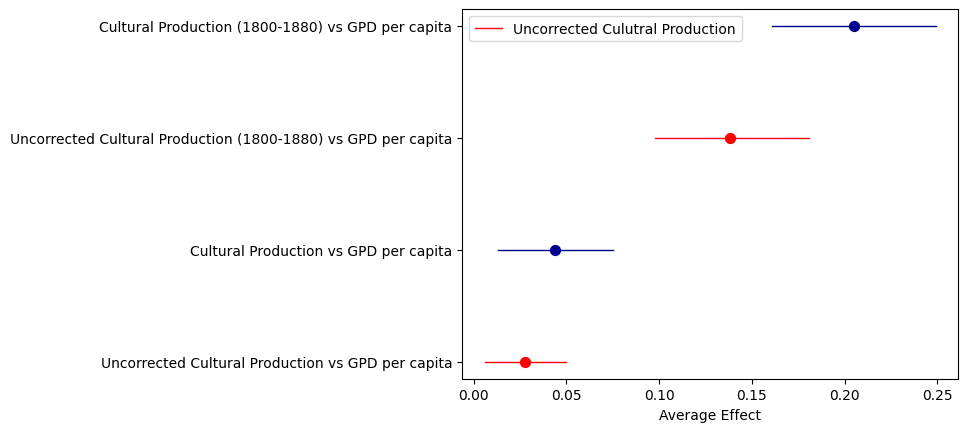

In [25]:
def make_table(corrected_index_fifty_fit, name="N_est_log_std"):


    summary_table_50 = az.summary(corrected_index_fifty_fit)
    #summary_table_50 = summary_table_50[['mean', 'sd', 'hdi_3%','hdi_97%']]
    summary_table_50 = summary_table_50.iloc[1]
    summary_table_50 = summary_table_50.reset_index()
    summary_table_50 = summary_table_50.set_index('index')
    summary_table_50.index.name = ""
    summary_table_50.columns = [name]

    return summary_table_50




table_1 = make_table(corrected_index_fifty_fit, name="N_est_log_std")
table_2 = make_table(score_index_fifty_fit, name="score_log_std")
table_3 = make_table(corrected_index_decade_fit, name="N_est_log_std (1800-1880)")
table_4 = make_table(score_index_decade_fit, name="score_log_std (1800-1880")


final_table = pd.concat([table_1, table_2, table_3, table_4], axis=1)

final_table = final_table[[ 'score_log_std',
                           'N_est_log_std',
 'score_log_std (1800-1880',
 'N_est_log_std (1800-1880)']]

final_table.columns = ['Uncorrected Cultural Production vs GPD per capita', 'Cultural Production vs GPD per capita', 'Uncorrected Cultural Production (1800-1880) vs GPD per capita', 'Cultural Production (1800-1880) vs GPD per capita']

# Adjusting the plot to ensure all HDI lines have the same thickness

fig, ax = plt.subplots()



# Colors and labels for different model types
colors = ['red' if 'Uncorrected' in model else 'darkblue' for model in final_table.columns]
labels = ['Corrected CPI' if 'Corrected' in model else 'Uncorrected Culutral Production' for model in final_table.columns]
used_labels = set()

# Plotting each model with their respective color and consistent HDI line thickness
for i, model in enumerate(final_table.columns):
    label = labels[i] if labels[i] not in used_labels else ""
    ax.plot([final_table.loc["hdi_3%", model], final_table.loc["hdi_97%", model]], [i, i],
            color=colors[i],  markersize=10, linewidth=1, label=label)  # Consistent HDI line thickness
    ax.scatter(final_table.loc["mean", model], i, color=colors[i], s=50)  # Mean scatter
    used_labels.add(labels[i])

ax.set_yticks(range(len(final_table.columns)))
ax.set_yticklabels(final_table.columns)
ax.set_xlabel('Average Effect')
ax.set_title('')

# Adding a legend to the plot
ax.legend()

#plt.tight_layout()
plt.show()


### Make a graph of the different alphas